Load the camera matrix and distortion coefficients from the previous calibration result

In [36]:
import cv2 
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# Load previously saved data
with np.load('calib.npz') as X:
    mtx, dist, _ , _ = [X[i] for i in ('mtx','dist','rvecs','tvecs')]

In [37]:
# Draw which takes the corners in the chessboard
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    para0 = tuple(imgpts[0].ravel())
    para1 = tuple(imgpts[1].ravel())
    para2 = tuple(imgpts[2].ravel())
    # cv2.line requires integer coordinates for drawing lines on images
    cv2.line(img, (int(corner[0]),int(corner[1])), (int(para0[0]),int(para0[1])) , (255,0,0), 5)
    cv2.line(img, (int(corner[0]),int(corner[1])), (int(para1[0]),int(para1[1])), (0,255,0), 5)
    cv2.line(img, (int(corner[0]),int(corner[1])), (int(para2[0]),int(para2[1])), (0,0,255), 5)    
    return img

X axis is drawn from (0,0,0) to (3,0,0), so for Y axis.
For Z axis, it is drawn from (0,0,0) to (0,0,-3).
Negative denotes it is drawn towards the camera.

In [38]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,300,0.001)
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

axis = np.float32([[3,0,0],[0,3,0],[0,0,-3]]).reshape(-1,3)

In [39]:
images = glob.glob('images/*.jpg')
print(images)
path_axis = "axis/"
if not os.path.exists(path_axis):
  os.makedirs(path_axis)

['images\\img1.jpg', 'images\\img10.jpg', 'images\\img11.jpg', 'images\\img12.jpg', 'images\\img13.jpg', 'images\\img14.jpg', 'images\\img15.jpg', 'images\\img16.jpg', 'images\\img2.jpg', 'images\\img3.jpg', 'images\\img4.jpg', 'images\\img5.jpg', 'images\\img6.jpg', 'images\\img7.jpg', 'images\\img8.jpg', 'images\\img9.jpg']


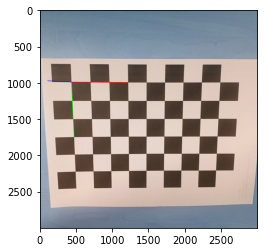

In [41]:
for name in images:
    img = cv2.imread(name)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # Find the rotation and translation vectors.
        _,rvecs, tvecs, inliers = cv2.solvePnPRansac(objp,corners2,mtx,dist)
        if np.allclose(tvecs, 0):
            print("tvecs: ", tvecs)
            print(name)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis,rvecs,tvecs,mtx,dist)

        img = draw(img,corners2,imgpts)
        plt.imshow(img)
        cv2.imwrite(os.path.join(path_axis , name[7:-4]+'_axis.jpg'), img)
        cv2.waitKey(100)

cv2.destroyAllWindows()

**Render a cube**

In [42]:
axis = np.float32([[0,0,0],[0,3,0],[3,3,0],[3,0,0],[0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3]])

def draw_cube(img,corners,imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    #  draw ground floor in green
    img = cv2.drawContours(img,[imgpts[:4]],-1,(0,255,0),-3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img,tuple(imgpts[i]),tuple(imgpts[j]),(255,0,0),3)

    # draw top layer in red color
    img = cv2.drawContours(img,[imgpts[4:]],-1,(0,0,255),3)

    return img

In [43]:
path_cube = "cube/"
if not os.path.exists(path_cube):
  os.makedirs(path_cube)
# for name in glob.glob('*image2.jpg'):
for name in images:
    img = cv2.imread(name)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # Find the rotation and translation vectors.
        _,rvecs, tvecs, inliers = cv2.solvePnPRansac(objp,corners2,mtx,dist)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis,rvecs,tvecs,mtx,dist)

        img = draw_cube(img,corners2,imgpts)
        cv2.imshow(name,img)
        cv2.imwrite(os.path.join(path_cube , name[7:-4]+'_cube.jpg'), img)
        cv2.waitKey(100)
        
cv2.destroyAllWindows()